# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Data Science: 

# Final Project Group 11: Predicting the Midterm Election


**Harvard University**<br/>
**Fall 2019**<br/>
**Students**: Justin Bassey, Jake Boll, Christopher Lewis, Sebastian Schwartz

<hr style="height:2pt">

## Exploratory Data Analysis

- What data are we dealing with?
- How have we explored the data (initial explorations, data cleaning and reconciliation, etc)? 
- Visualizations and captions that summarize the noteworthy findings of the EDA.
- A revised project question based on the insights you gained through EDA (specific to data).
- A baseline model.

**Data Collection**

We got our congressional district demographic data from American Community Surveys (ACS) on Census.gov, dating back to 2010. We then merged this demographics data with the House election results from Harvard's Dataverse, as well as the data we scrapped from the American Presidency Project about seats lost and gained during each sitting president's midterm. 

### Project Goal 
The primary goal of this project is to explain the outcomes of the 2018 midterm
elections in the House. Any piece of information from before election day can be used to perform
this analysis, but the suggested feature set should include past elections, polling data, and demographic information of congressional districts

In [0]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import requests
from bs4 import BeautifulSoup

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

import statsmodels.api as sm
from statsmodels.api import OLS


%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

### House District Candidate Data

In [0]:
# import house data
house_district_data = pd.read_csv('https://raw.githubusercontent.com/Bassatron/houseMidterms2018/master/data/1976_2018_house.csv')

# add winners column
house_district_data['winner'] = 0
# drop unecessary columns
to_drop = ['state_fips', 'state_cen', 'state_ic', 'office', 'stage', 'runoff', 'special', 'mode', 'unofficial', 
           'version']
house_district_data.drop(to_drop, inplace=True, axis=1)

#clean data types
house_district_data['candidatevotes'] = house_district_data['candidatevotes'].str.replace(',','')
house_district_data['candidatevotes'] = house_district_data['candidatevotes'].apply(pd.to_numeric)
# rename state po to abr
house_district_data.rename(columns={"state_po": "state_abr"}, inplace=True)

house_district_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29636 entries, 0 to 29635
Data columns (total 10 columns):
year              29636 non-null int64
state             29636 non-null object
state_abr         29636 non-null object
district          29636 non-null int64
candidate         27516 non-null object
party             26214 non-null object
writein           29636 non-null bool
candidatevotes    29636 non-null int64
totalvotes        29636 non-null float64
winner            29636 non-null int64
dtypes: bool(1), float64(1), int64(4), object(4)
memory usage: 2.1+ MB


In [0]:
# values for districts, years, and states
district_nums = house_district_data.district.unique()
district_years = house_district_data.year.unique()
states = house_district_data.state.unique()

In [0]:
# update winners data column
# THIS FUNCTION TAKES A WHILE
for state in states:
    for year in house_district_data.year.unique():
        for district in house_district_data.district.unique():
            try:
                index = house_district_data['candidatevotes'].loc[(house_district_data['state'] == state) &
                                                                  (house_district_data['year'] == year) &
                                                                  (house_district_data['district'] == district)].idxmax
                house_district_data.at[index, 'winner'] = 1
            except:
                pass

house_district_data.head()

,year,state,state_abr,district,candidate,party,writein,candidatevotes,totalvotes,winner
0,1976,Alabama,AL,1,Bill Davenport,democrat,False,58906,157170.0,0
1,1976,Alabama,AL,1,Jack Edwards,republican,False,98257,157170.0,1
2,1976,Alabama,AL,1,NaN,NaN,True,7,157170.0,0
3,1976,Alabama,AL,2,J. Carole Keahey,democrat,False,66288,156362.0,0
4,1976,Alabama,AL,2,NaN,NaN,True,5,156362.0,0


In [0]:
district_years[1::2]

array([1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018])

In [0]:
# Find nas
house_district_data.isna().sum()

# drop rows with no candidate
house_district_data = house_district_data.dropna(subset=['candidate'])
# fill party
house_district_data['party'] = house_district_data['party'].fillna('Unknown')

display(house_district_data.isna().sum())

year              0
state             0
state_abr         0
district          0
candidate         0
party             0
writein           0
candidatevotes    0
totalvotes        0
winner            0
dtype: int64

### How do states traditionally vote?

In [0]:
dems = house_district_data.loc[house_district_data['party'] == 'democrat']
gops = house_district_data.loc[house_district_data['party'] == 'republican']


democry = dems.groupby(['state']).agg(({
    'candidatevotes': np.mean
}))

gopcry = gops.groupby(['state']).agg(({
    'candidatevotes': np.mean
}))

democratic = democry-gopcry
democratic['positive'] = democratic['candidatevotes'] > 0
democratic.head(5)

,candidatevotes,positive
state,,
Alabama,-15245.372434,False
Alaska,-57676.272727,False
Arizona,-26704.691560,False
Arkansas,-9562.144026,False
California,17121.275155,True


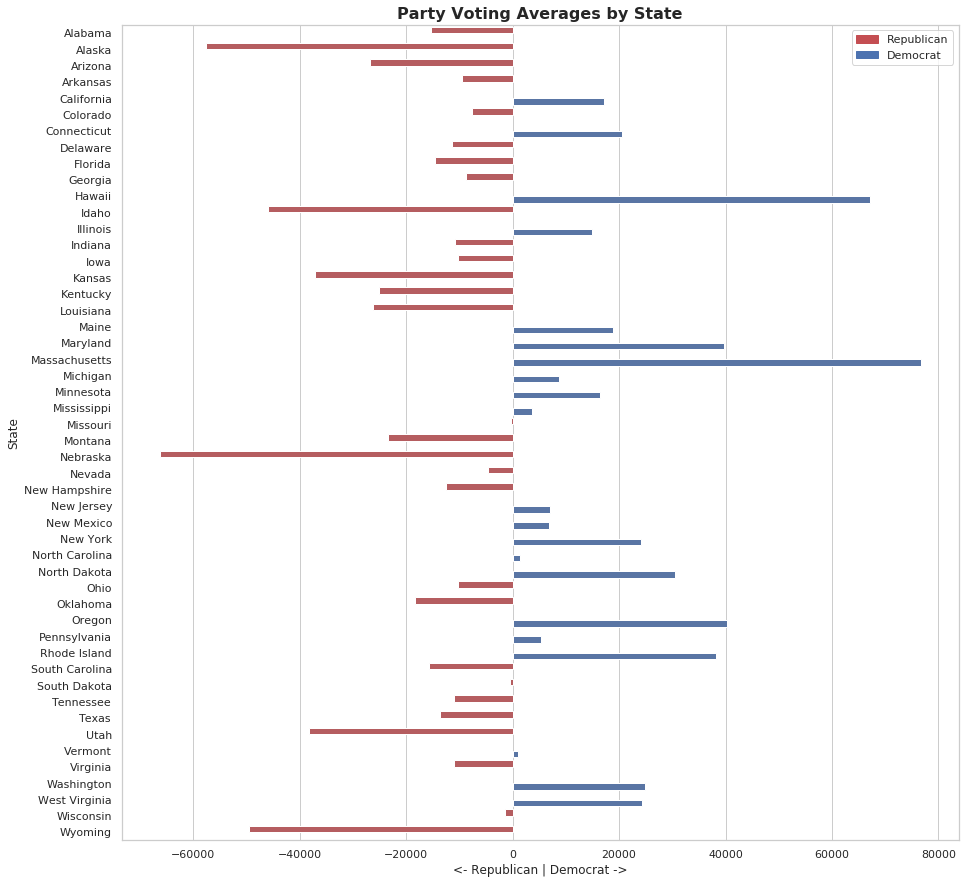

In [0]:
# show average vote
fig, ax = plt.subplots(figsize=(15,15))

sns.barplot(x='candidatevotes', y=democratic.index, data=democratic, hue='positive', palette=['r', 'b'])

ax.set(xlabel='<- Republican | Democrat ->', ylabel='State')
ax.set_title('Party Voting Averages by State', fontsize=16, fontweight='bold')
# legend
red_patch = mpatches.Patch(color='r', label='Republican')
blue_patch = mpatches.Patch(color='b', label='Democrat')
plt.legend(handles=[red_patch, blue_patch], loc='upper right')
plt.show()

### House Seat Changes by President

In [0]:
house_seat_change = requests.get("https://www.presidency.ucsb.edu/statistics/data/seats-congress-gainedlost-the-presidents-party-mid-term-elections")

In [0]:
seats_soup = BeautifulSoup(house_seat_change.content, 'html.parser') 

In [0]:
def get_year(tag):
    return tag.find_all('td')[0].text

def get_president(tag):
    return tag.find_all('td')[2].text

def get_pres_party(tag):
    return tag.find_all('td')[3].text
    
def get_party_seats_to_defend(tag):
    return tag.find_all('td')[10].text.strip()
    
def get_house_seat_change(tag):
    return tag.find_all('td')[12].text
    
def parse_presidents(seats_soup):
    preslist = []
    
    pres_soup = seats_soup.find('tbody').find_all('tr')
    for i in range(len(pres_soup)):
        pres_dict = {
            'year': get_year(pres_soup[i]),
            'president': get_president(pres_soup[i]),
            'party': get_pres_party(pres_soup[i]),
            'seats to defend': get_party_seats_to_defend(pres_soup[i]),
            'seat change': get_house_seat_change(pres_soup[i])
        }
        preslist.append(pres_dict)
    return preslist

# fix data types
seat_change_by_president = pd.DataFrame(parse_presidents(seats_soup))
seat_change_by_president[['seat change', 'seats to defend', 'year']] = seat_change_by_president[['seat change', 'seats to defend', 'year']].apply(pd.to_numeric)
# rename columns
seat_change_by_president.rename(columns={'party': 'president_party', 'president': 'sitting_president'}, inplace=True)
seat_change_by_president.head()


,year,sitting_president,president_party,seats to defend,seat change
0,1934,Franklin D. Roosevelt,D,313,9
1,1938,Franklin D. Roosevelt,D,334,-81
2,1942,Franklin D. Roosevelt,D,267,-46
3,1946,Harry S. Truman,D,244,-45
4,1950,Harry S. Truman,D,263,-29


**Are there differences in House seats lost by Democratic vs Republican Presidents?**

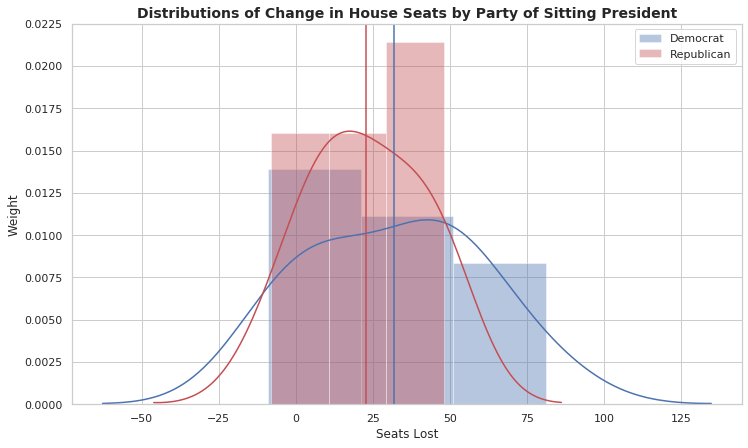

Average Democratic Seats Lost: 31.75
Average Republican Seats Lost: 22.7


In [0]:
dem_seat_change = -1 * seat_change_by_president['seat change'].loc[seat_change_by_president['president_party'] == 'D']
rep_seat_change = -1 * seat_change_by_president['seat change'].loc[seat_change_by_president['president_party'] == 'R']

fig, ax = plt.subplots(figsize=(12,7))

# plot seat change by party
sns.distplot(dem_seat_change, label='Democrat', color='b')
sns.distplot(rep_seat_change, label='Republican', color='r')

# plot average seat loss
plt.axvline(dem_seat_change.mean(), color='b')
plt.axvline(rep_seat_change.mean(), color='r')

ax.set(ylabel='Weight', xlabel='Seats Lost')
ax.set_title('Distributions of Change in House Seats by Party of Sitting President', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.show()

print('Average Democratic Seats Lost:', dem_seat_change.mean())
print('Average Republican Seats Lost:', rep_seat_change.mean())


We can see that Democrats tend to lose more seats than Republicans.

**What do the district level demographics look like?**

In [0]:
# No longer using this data

# # load in data
# district_demo = {}
# for state in states:
#     csv = (state + '_District_all.csv')
#     url = 'https://raw.githubusercontent.com/Bassatron/houseMidterms2018/master/data/state_districts/{}'.format(csv).replace(' ', '_')
#     print('Loading: {}'.format(url))
#     district_demo[state] = pd.read_csv(url).drop(['Topic', 'Subject'], axis=1).transpose()
#     # clean data
#     district_demo[state].columns = district_demo[state].iloc[0]
#     district_demo[state] = district_demo[state].drop(['Title'])
#     district_demo[state] = district_demo[state].dropna(axis='columns', how='all')
#     # add district column
#     district_demo[state]['district'] = 0
#     dist_lens = range(1,len(district_demo[state].iloc[::2])+1)
#     district_demo[state].iloc[::2]['district'] = dist_lens
#     # add year column
#     district_demo[state]['year'] = 2018
#     # add state name column
#     district_demo[state]['state'] = state

# concat all state districts together
# all_dist_demo = pd.concat(district_demo)
# all_dist_demo = all_dist_demo.loc[::2].apply(pd.to_numeric, errors='ignore')
# all_dist_demo.dtypes
    


In [0]:
def clean_demo(x):
    # Fix column names
    x.columns = x.iloc[0]
    x.drop([0], inplace=True)
    x.drop(['id'], axis=1, inplace=True)

    # rename columns
    for col in x.columns:
        x.rename(columns={col: re.sub('Estimate|!.+!', '', col)}, inplace=True)

    # filter out margin and percentage columns
    x = x.filter(regex='^((?!Margin|Percent).)*$')

    # add district and state columns
    districts = []
    states = []
    for dist in x['Geographic Area Name']:
        if re.split('\s', dist)[2].isnumeric() == True:
            districts.append(re.split('\s', dist)[2])
        else:
            districts.append(0)
        states.append(re.split('\s', dist)[-1])
    x['state'] = states
    x['district'] = districts
    
    return x

In [0]:
# load data
demo2010 = pd.read_csv('https://raw.githubusercontent.com/Bassatron/houseMidterms2018/master/data/ACS_data/acs_2010.csv')
demo2012 = pd.read_csv('https://raw.githubusercontent.com/Bassatron/houseMidterms2018/master/data/ACS_data/acs_2012.csv')
demo2014 = pd.read_csv('https://raw.githubusercontent.com/Bassatron/houseMidterms2018/master/data/ACS_data/acs_2014.csv')
demo2016 = pd.read_csv('https://raw.githubusercontent.com/Bassatron/houseMidterms2018/master/data/ACS_data/acs_2016.csv')
demo2018 = pd.read_csv('https://raw.githubusercontent.com/Bassatron/houseMidterms2018/master/data/ACS_data/acs_2018.csv')

# cleaned data
demo2010 = clean_demo(demo2010)
demo2012 = clean_demo(demo2012)
demo2014 = clean_demo(demo2014)
demo2016 = clean_demo(demo2016)
demo2018 = clean_demo(demo2018)

# add year column
demo2010['year'] = 2010
demo2012['year'] = 2012
demo2014['year'] = 2014
demo2016['year'] = 2016
demo2018['year'] = 2018



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
# drop duplicated columns
demo2010 = demo2010.loc[:, ~demo2010.columns.duplicated()]
demo2012 = demo2012.loc[:, ~demo2012.columns.duplicated()]
demo2014 = demo2014.loc[:, ~demo2014.columns.duplicated()]
demo2016 = demo2016.loc[:, ~demo2016.columns.duplicated()]
demo2018 = demo2018.loc[:, ~demo2018.columns.duplicated()]

frames = [demo2010, demo2012, demo2014, demo2016, demo2018]

# concat all dat
all_dist_demo = pd.concat(frames)

# clean column name
all_dist_demo.rename(columns={'!!Total housing units': 'Total housing units'}, inplace=True)

# convert to numeric 
all_dist_demo = all_dist_demo.apply(pd.to_numeric, errors='ignore')




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


### Data Cleaning and Merging

In [0]:
# merge president data with house data
# We only care about midterm years, so we're dropping non-midterm elections
house_plus_president = pd.merge(house_district_data, seat_change_by_president, on='year')
house_plus_president.head()
house_plus_president.shape


(13236, 14)

In [0]:
# Final data (demographics are repeated from 2018)
data_all = pd.merge(house_plus_president, all_dist_demo, on=['state', 'district', 'year'])

# drop duplicated columns
data_all = data_all.loc[:, ~data_all.columns.duplicated()]
display(data_all.shape)
data_all.info(verbose=True)

(3054, 82)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054 entries, 0 to 3053
Data columns (total 82 columns):
year                                                               3054 non-null int64
state                                                              3054 non-null object
state_abr                                                          3054 non-null object
district                                                           3054 non-null int64
candidate                                                          3054 non-null object
party                                                              3054 non-null object
writein                                                            3054 non-null bool
candidatevotes                                                     3054 non-null int64
totalvotes                                                         3054 non-null float64
winner                                                             3054 non-null int64
sitting_president 

In [0]:
data_all.head()

,year,state,state_abr,district,candidate,party,writein,candidatevotes,totalvotes,winner,sitting_president,president_party,seats to defend,seat change,Total housing units,10 to 14 years,15 to 19 years,16 years and over,18 years and over,20 to 24 years,21 years and over,25 to 34 years,35 to 44 years,45 to 54 years,5 to 9 years,55 to 59 years,60 to 64 years,62 years and over,65 to 74 years,65 years and over,75 to 84 years,85 years and over,American Indian and Alaska Native,American Indian and Alaska Native alone,Asian,Asian Indian,Asian alone,Black or African American,Black or African American alone,Black or African American and American Indian and Alaska Native,Cherokee tribal grouping,Chinese,Chippewa tribal grouping,"Citizen, 18 and over population",Cuban,Female,Filipino,Geographic Area Name,Guamanian or Chamorro,Hispanic or Latino (of any race),Japanese,Korean,Male,Median age (years),Mexican,Native Hawaiian,Native Hawaiian and Other Pacific Islander,Native Hawaiian and Other Pacific Islander alone,Navajo tribal grouping,Not Hispanic or Latino,One race,Other Asian,Other Hispanic or Latino,Other Pacific Islander,Puerto Rican,Samoan,Sex ratio (males per 100 females),Sioux tribal grouping,Some other race,Some other race alone,Total population,Two or more races,"Two races excluding Some other race, and Three or more races",Two races including Some other race,Under 18 years,Under 5 years,Vietnamese,White,White alone,White and American Indian and Alaska Native,White and Asian,White and Black or African American
0,2010,Alabama,AL,1,Jo Bonner,republican,False,129063,156281.0,1,Barack Obama,D,257,-63,324851,50189,50818,NaN,520700,42157,492468,84725,87856,101092,43212,46316,39928,121333,56602,98883,31847,10434,8000,7244,9816,1552,9816,194656,194196,751,N,613,N,NaN,831,351705,625,"Congressional District 1 (111th Congress), Ala...",N,19394,393,345,338130,38.4,11571,N,53,0,N,670441,681845,893,5546,N,1446,N,NaN,N,4551,508,689835,7990,7563,41,NaN,44659,5395,464769,451073,3132,1436,2075
1,2010,Alabama,AL,1,David Walter,constitution,False,26357,156281.0,0,Barack Obama,D,257,-63,324851,50189,50818,NaN,520700,42157,492468,84725,87856,101092,43212,46316,39928,121333,56602,98883,31847,10434,8000,7244,9816,1552,9816,194656,194196,751,N,613,N,NaN,831,351705,625,"Congressional District 1 (111th Congress), Ala...",N,19394,393,345,338130,38.4,11571,N,53,0,N,670441,681845,893,5546,N,1446,N,NaN,N,4551,508,689835,7990,7563,41,NaN,44659,5395,464769,451073,3132,1436,2075
2,2010,Alabama,AL,2,Bobby Bright,democrat,False,106865,219028.0,0,Barack Obama,D,257,-63,301606,43625,44000,NaN,508108,49544,480407,83940,89114,92614,46456,44183,37960,114213,52054,92707,29554,11099,2713,2713,5874,1536,5753,206236,205085,559,N,960,N,NaN,332,347144,863,"Congressional District 2 (111th Congress), Ala...",N,18587,496,929,319635,37.7,9306,N,179,179,N,648192,652506,408,5164,N,3785,N,NaN,N,5838,85,666779,14273,12498,399,NaN,42636,682,431666,421480,3735,1029,5563
3,2010,Alabama,AL,2,Martha Roby,republican,False,111645,219028.0,1,Barack Obama,D,257,-63,301606,43625,44000,NaN,508108,49544,480407,83940,89114,92614,46456,44183,37960,114213,52054,92707,29554,11099,2713,2713,5874,1536,5753,206236,205085,559,N,960,N,NaN,332,347144,863,"Congressional District 2 (111th Congress), Ala...",N,18587,496,929,319635,37.7,9306,N,179,179,N,648192,652506,408,5164,N,3785,N,NaN,N,5838,85,666779,14273,12498,399,NaN,42636,682,431666,421480,3735,1029,5563
4,2010,Alabama,AL,3,Mike Rogers,republican,False,117736,198139.0,1,Barack Obama,D,257,-63,318023,47300,56857,NaN,529722,57123,486844,83358,88008,95136,40430,45658,39782,114230,52428,91673,28964,10281,1187,1006,8472,633,8472,221144,219206,852,N,1892,N,NaN,74,356523,463,"Congressional District 3 (111th Congress), Ala...",N,21026,370,3068,333558,36.7,14709,N,122,122,N,669055,683523,2028,3147,N,3096,N,NaN,N,7118,54,690081,6558,6347,0,NaN,44756,18,445480,433848,2319,909,1285


**Trim our features into something useable for an exploratory regression**

In [0]:
data_all[data_all['winner'] == 1].party.value_counts().head()

republican                 597
democrat                   494
democratic-farmer-labor      8
Name: party, dtype: int64

We see that candidates outside the major two parties basically never win - so let's only look at the main two parties.

We also need to merge rows for tickets that were competing in the same election (where district and year are equal), as our predictive task will be predicting the winner.

We assign boolean values for party - democrat = 0, republican = 1. Our winner variable is changed here from representing success to representing the party that won, once we merge the tickets.

In [0]:
data_all = data_all[data_all.party.isin(['democrat', 'republican'])]

# code democrats as 0, republicans as 1
data_party_adjusted = data_all.copy()
data_party_adjusted.party = data_all.party.apply(lambda x: 0 if x == 'democrat' else 1).astype(int)
data_party_adjusted.president_party = data_all.president_party.apply(lambda x: 0 if x == 'D' else 1).astype(int)

# merge tickets - look only at the winning ticket for each
# year and district, and then we change the 'winner' variable to be the 
# coded variable of which party won
data_party_adjusted = data_party_adjusted[data_party_adjusted.winner == 1]
data_party_adjusted['winner_party'] = (data_party_adjusted['party'] == data_party_adjusted.winner).astype(int)

# check that this is the same as above
data_party_adjusted.winner_party.value_counts()

1    597
0    494
Name: winner_party, dtype: int64

In [0]:
## columns we almost certainly want to drop

columns_to_drop = [
                   
    # same for all entries
    'party', 'winner', 'writein',

    # just labels, not predictive
    'sitting_president', 'candidate', 'state', 'state_abr', 'district', 'Geographic Area Name',

    # using these would be cheating
    'candidatevotes', 'totalvotes', 'seat change',

]

# nationalities: these are unlikely to be helpful 
columns_to_drop += [
    'Mexican', 'Puerto Rican', 'Cuban', 'Other Hispanic or Latino',
    'American Indian and Alaska Native',	'American Indian and Alaska Native alone', 'Asian Indian',	'Asian alone',
    'Black or African American alone', 'Cherokee tribal grouping', 'Black or African American and American Indian and Alaska Native',
    'Chinese',	'Chippewa tribal grouping', 'Filipino', 'Guamanian or Chamorro', 'Japanese',	'Korean', 'Native Hawaiian', 
    'Native Hawaiian and Other Pacific Islander', 'Native Hawaiian and Other Pacific Islander alone', 'Navajo tribal grouping',
    'Other Asian', 'Other Pacific Islander', 'Samoan', 'Vietnamese', 'White alone'
]

# we keep major racial groups but drop these hybrid categories
columns_to_drop += [
    'One race', 'Two or more races', 'Not Hispanic or Latino', 'Some other race', 'Two races excluding Some other race, and Three or more races',
    'Two races including Some other race', 'White and American Indian and Alaska Native',	'White and Asian',
    'White and Black or African American'
]

# we already have the median age, don't need age buckets
columns_to_drop += [
  'Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 34 years',
  '35 to 44 years', '45 to 54 years', '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years',
  '65 years and over', '85 years and over', '65 years and over'
]

# significant NA
columns_to_drop += [
  '16 years and over', 'Citizen, 18 and over population', 'Sex ratio (males per 100 females)',	'Sioux tribal grouping',	'Some other race alone',
  'Under 18 years'
]


data_subsetted = data_party_adjusted.drop(columns_to_drop, axis=1)

In [0]:
data_subsetted.head()

,year,president_party,seats to defend,Total housing units,18 years and over,21 years and over,62 years and over,Asian,Black or African American,Female,Hispanic or Latino (of any race),Male,Median age (years),Total population,White,winner_party
0,2010,0,257,324851,520700,492468,121333,9816,194656,351705,19394,338130,38.4,689835,464769,1
3,2010,0,257,301606,508108,480407,114213,5874,206236,347144,18587,319635,37.7,666779,431666,1
4,2010,0,257,318023,529722,486844,114230,8472,221144,356523,21026,333558,36.7,690081,445480,1
6,2010,0,257,298854,502685,476033,129100,2385,34217,333320,41506,325832,40.2,659152,600810,1
8,2010,0,257,319162,550816,518615,122231,10577,126927,367036,33298,352870,38.3,719906,552254,1


We need to turn some stats into percentages not absolute numbers by dividing by total population.

Otherwise any normalization applied across the whole data set won't account for differences in population between elections

In [0]:

data_proportioned = data_subsetted.copy()

proportional_fields = [
  'Male',
  'Female',
  'White',
  'Black or African American',
  'Asian',
  'Hispanic or Latino (of any race)'
]

for field in proportional_fields:
  data_proportioned[field] = data_proportioned[field] / data_proportioned['Total population']

Create our initial train test split for the exploratory model and normalize using MinMaxScaler between 0 and 1.



In [0]:
def split_and_normalize(data):

  x_train = data[data.year != 2018].drop(['winner_party', 'year'], axis=1)
  y_train = data[data.year != 2018].winner_party
  x_test = data[data.year == 2018].drop(['winner_party', 'year'], axis=1)
  y_test = data[data.year == 2018].winner_party

  dont_normalize_cols = [

      # these are binary, don't normalize         
      'president_party',
      'party',
      'party_same_as_president'
  ]

  dont_normalize_cols += proportional_fields

  normalize_cols = [x for x in x_train.columns if x not in dont_normalize_cols]

  scaler = MinMaxScaler()
  scaler.fit(x_train[normalize_cols])

  x_train_scaled = x_train.copy()
  x_test_scaled = x_test.copy()

  x_train_scaled[normalize_cols] = scaler.transform(x_train[normalize_cols])
  x_test_scaled[normalize_cols] = scaler.transform(x_test[normalize_cols])
  return x_train_scaled, x_test_scaled, y_train, y_test


In [0]:
x_train_scaled, x_test_scaled, y_train, y_test = split_and_normalize(data_proportioned)
x_train_scaled.describe()

,president_party,seats to defend,Total housing units,18 years and over,21 years and over,62 years and over,Asian,Black or African American,Female,Hispanic or Latino (of any race),Male,Median age (years),Total population,White
count,729.0,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000
mean,0.0,0.500686,0.374918,0.401631,0.399209,0.320293,0.048993,0.121208,0.507349,0.169793,0.492651,0.410543,0.391695,0.745668
std,0.0,0.500343,0.112295,0.110853,0.111523,0.119841,0.064750,0.143129,0.009536,0.183396,0.009536,0.139708,0.115420,0.168303
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.002061,0.003624,0.463994,0.006059,0.451051,0.000000,0.000000,0.185333
25%,0.0,0.000000,0.310477,0.335792,0.332365,0.244085,0.014556,0.032443,0.501212,0.044616,0.486713,0.328185,0.331260,0.668687
50%,0.0,1.000000,0.373720,0.404419,0.398497,0.313723,0.025202,0.066346,0.507488,0.098851,0.492512,0.409266,0.390915,0.783899
75%,0.0,1.000000,0.433448,0.463558,0.459966,0.374100,0.053425,0.143791,0.513287,0.218307,0.498788,0.498069,0.445619,0.875747
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.531723,0.677607,0.548949,0.868706,0.536006,1.000000,1.000000,0.970381


In [0]:
x_test_scaled.describe()

,president_party,seats to defend,Total housing units,18 years and over,21 years and over,62 years and over,Asian,Black or African American,Female,Hispanic or Latino (of any race),Male,Median age (years),Total population,White
count,362.0,3.620000e+02,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000
mean,1.0,7.142857e-01,0.407528,0.475444,0.476178,0.424231,0.054835,0.121134,0.506686,0.185466,0.493314,0.445775,0.446973,0.730543
std,0.0,2.890575e-15,0.109914,0.100590,0.102683,0.129495,0.070627,0.137975,0.009220,0.188639,0.009220,0.144553,0.098062,0.168930
min,1.0,7.142857e-01,0.075983,0.153628,0.157589,0.145596,0.002016,0.004759,0.473163,0.007606,0.462533,0.057915,0.126506,0.172648
25%,1.0,7.142857e-01,0.348482,0.413445,0.415237,0.345731,0.016939,0.034718,0.500549,0.053537,0.488020,0.359073,0.382325,0.640591
50%,1.0,7.142857e-01,0.412036,0.460887,0.464594,0.417779,0.030036,0.066479,0.506455,0.115862,0.493545,0.440154,0.440028,0.774553
75%,1.0,7.142857e-01,0.465809,0.530975,0.534739,0.477172,0.061797,0.147879,0.511980,0.249197,0.499451,0.524131,0.500667,0.863688
max,1.0,7.142857e-01,0.926409,1.052561,1.039444,1.156897,0.562894,0.672547,0.537467,0.876271,0.526837,1.111969,1.001950,0.970217


## Modeling the Data

### Exploratory Baseline Model

**We produce a simple exploratory linear regression to get a feel for what predictors might be important**

After producing this exploratory regression, we bootstrap to build up a map of p values for our predictors to get a sense of which predictors will be the most important for us.

In [0]:
# to get our p-values, use OLS not sklearn

x_train_const = sm.add_constant(x_train_scaled)
exporatory_model = sm.OLS(y_train, x_train_const).fit()
y_train_pred = exporatory_model.predict(x_train_const)

# need the has_constant option bc if there is a column with variance=0
# it won't add one by default - in this case president_party is constant for test data
x_test_const = sm.add_constant(x_test_scaled, has_constant='add')
y_test_pred = exporatory_model.predict(x_test_const)

base_train_score = r2_score(y_train, y_train_pred)
base_test_score = r2_score(y_test, y_test_pred)

print('base_train_score: {:.3f}\nbase_test_score: {:.3f}'.format(base_train_score, base_test_score))


base_train_score: 0.406
base_test_score: 0.330


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
exporatory_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           winner_party   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     40.75
Date:                Thu, 12 Dec 2019   Prob (F-statistic):           6.65e-73
Time:                        00:09:20   Log-Likelihood:                -329.84
No. Observations:                 729   AIC:                             685.7
Df Residuals:                     716   BIC:                             745.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -0.8465      0.212     -3.991      0.000      -1.263      -0.430
president_party                   1.559e-15    9.2e-16      1.694      0.091   -2.48e-16    3.37e-15
seats to defend                      0.0242      0.035      0.695      0.487      -0.044       0.092
Total housing units                 -0.5091      0.288     -1.765      0.078      -1.075       0.057
18 years and over                   -2.4751      1.197     -2.068      0.039      -4.825      -0.125
21 years and over                   -0.9267      1.270     -0.730      0.466      -3.420       1.566
62 years and over                    1.0839      0.361      3.006      0.003       0.376       1.792
Asian                                1.1117      0.543      2.049      0.041       0.047       2.177
Black or African American            1.2425      0.354      3.513      0.000       0.548       1.937
Female                              -5.7357      1.040     -5.514      0.000      -7.778      -3.693
Hispanic or Latino (of any race)    -0.6268      0.126     -4.981      0.000      -0.874      -0.380
Male                                 4.8892      1.004      4.872      0.000       2.919       6.859
Median age (years)                   0.2431      0.342      0.712      0.477      -0.427       0.914
Total population                     3.8417      0.460      8.352      0.000       2.939       4.745
White                                1.9050      0.327      5.822      0.000       1.263       2.547
==============================================================================
Omnibus:                       42.323   Durbin-Watson:                   1.615
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.364
Skew:                          -0.534   Prob(JB):                     1.04e-09
Kurtosis:                       2.529   Cond. No.                     3.29e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.2e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We can see that many of our predictors are not very significant. To look into this further, we bootstrap across many samples of the data to produce a more accurate picture of which predictors are significant in our linear regression.

In [0]:
def sample(x_train, y_train, size=0.6):
  x_sample = x_train.sample(n = int(size * len(x_train)))
  y_sample = y_train[x_sample.index]
  return x_sample, y_sample

coeff_bootstraps = []
pvalue_bootstraps = []
for i in range(100):
  x_sample, y_sample = sample(x_train_scaled, y_train)

  x_const = sm.add_constant(x_sample)
  model = sm.OLS(y_sample, x_const).fit()
  pvalue_bootstraps.append(model.pvalues)
  coeff_bootstraps.append(model.params)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
mean_pvals = {}
mean_coeffs = {}
for i in range(len(pvalue_bootstraps[0])):
  vals = [x[i] for x in pvalue_bootstraps]
  coeffs = [x[i] for x in coeff_bootstraps]
  mean_pvals[pvalue_bootstraps[0].index[i]] = np.mean(vals)
  mean_coeffs[pvalue_bootstraps[0].index[i]] = np.mean(coeffs)

pvals_and_coeffs = []
for k in mean_pvals:
  pvals_and_coeffs.append({
      'predictor': k,
      'mean_p_value': mean_pvals[k],
      'mean_coefficient': mean_coeffs[k],
      'predicts': 'D' if mean_coeffs[k] < 0 else 'R'
  })
pval_df = pd.DataFrame(pvals_and_coeffs)
pval_df.sort_values(by='mean_p_value', inplace=True)
pval_df.head(30).round(5)

,predictor,mean_p_value,mean_coefficient,predicts
13,Total population,0.00000,3.87967,R
9,Female,0.00027,-5.76404,D
14,White,0.00029,1.95914,R
11,Male,0.00158,4.89245,R
10,Hispanic or Latino (of any race),0.00381,-0.62203,D
0,const,0.01260,-0.87159,D
8,Black or African American,0.01689,1.29142,R
6,62 years and over,0.04076,1.11010,R
7,Asian,0.13318,1.22077,R
4,18 years and over,0.17932,-2.57004,D


### Lasso Model

We use a Lasso linear regression to try perform some variable selection on the data.

In [0]:
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(cv=5)

lasso_model.fit(x_train_scaled, y_train)

lasso_train_score = lasso_model.score(x_train_scaled, y_train)
lasso_test_score = lasso_model.score(x_test_scaled, y_test)

print('lasso_train_score: {:.3f}\nlasso_test_score: {:.3f}'.format(lasso_train_score, lasso_test_score))



lasso_train_score: 0.406
lasso_test_score: 0.334


### Ridge Model

We use a Ridge linear regression model.

In [0]:
from sklearn.linear_model import RidgeCV

ridge_model = LassoCV(cv=5)

ridge_model.fit(x_train_scaled, y_train)

ridge_train_score = ridge_model.score(x_train_scaled, y_train)
ridge_test_score = ridge_model.score(x_test_scaled, y_test)

print('ridge_train_score: {:.3f}\nridge_test_score: {:.3f}'.format(ridge_train_score, ridge_test_score))

ridge_train_score: 0.406
ridge_test_score: 0.334


### FiveThirtyEight Prediction Data

Using this data may be cheating, but just for interest here's FiveThirtyEights predictions for House 2018

In [0]:
fte_predictions = pd.read_csv('https://projects.fivethirtyeight.com/congress-model-2018/house_district_forecast.csv')
fte_predictions = fte_predictions[fte_predictions.model == 'classic']
fte_predictions = fte_predictions.drop(['special'], axis=1)
fte_predictions.head()

,forecastdate,state,district,candidate,party,incumbent,model,win_probability,voteshare,p10_voteshare,p90_voteshare
0,2018-08-01,AK,1,Don Young,R,True,classic,0.7185,49.35,43.04,55.59
1,2018-08-01,AK,1,Alyse S. Galvin,D,False,classic,0.2815,44.11,37.77,50.39
2,2018-08-01,AK,1,Others,NaN,False,classic,0.0000,6.54,2.60,11.17
3,2018-08-01,AL,1,Bradley Byrne,R,True,classic,0.9993,64.90,59.71,69.94
4,2018-08-01,AL,1,Robert Kennedy Jr.,D,False,classic,0.0007,35.10,30.06,40.29


### Random Forests 

In [0]:
#get the necesary packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [0]:
#controls for inputs
n_trees = 65
tree_depth = 10

#create and fit the model
rfc = RandomForestClassifier(n_estimators=n_trees, max_depth=tree_depth, max_features='sqrt', random_state=42)
rfc.fit(x_train_scaled, y_train)

#make predictions
rfc_train_preds = rfc.predict(x_train_scaled)
rfc_test_preds = rfc.predict(x_test_scaled)

#find and report scores
random_forest_train_score = accuracy_score(y_train, rfc_train_preds)
random_forest_test_score = accuracy_score(y_test, rfc_test_preds)
print('Random forest train accuracy: {}'.format(random_forest_train_score))
print('Random forest test accuracy: {}'.format(random_forest_test_score))


Random forest train accuracy: 0.9807956104252401
Random forest test accuracy: 0.8204419889502762


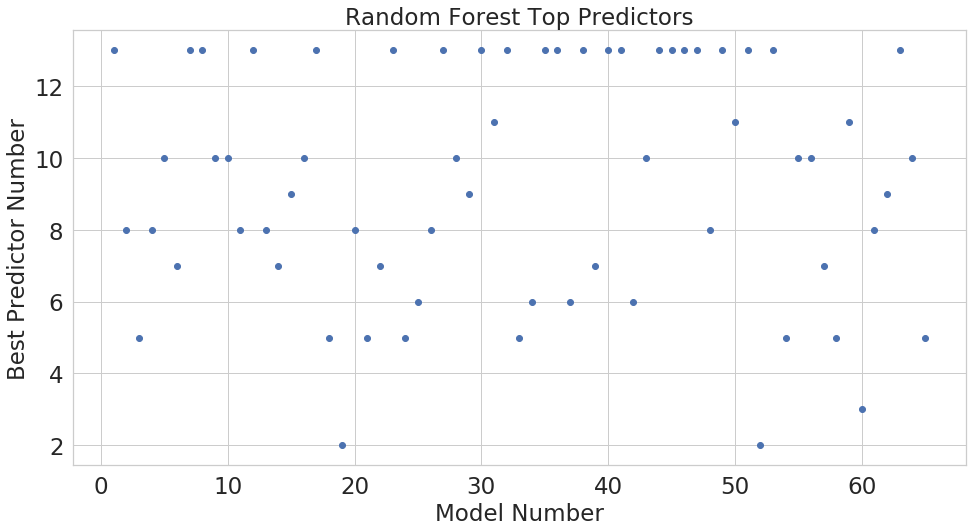

In [0]:
#Taking a look at the most important predictors in our Random Forest Model

#get list of predictors 
top_preds_rf = []
for model in rfc.estimators_:
    top_preds_rf.append(model.tree_.feature[0])
    

#Visual representation of the results
fig, ax = plt.subplots(1,1, figsize=(16, 8))

ax.scatter(np.arange(1, len(top_preds_rf)+1), top_preds_rf)
ax.set_title('Random Forest Top Predictors', fontsize=f_size)

ax.set_xlabel('Model Number', fontsize=f_size)
ax.set_ylabel('Best Predictor Number', fontsize=f_size)
ax.tick_params(labelsize=f_size)



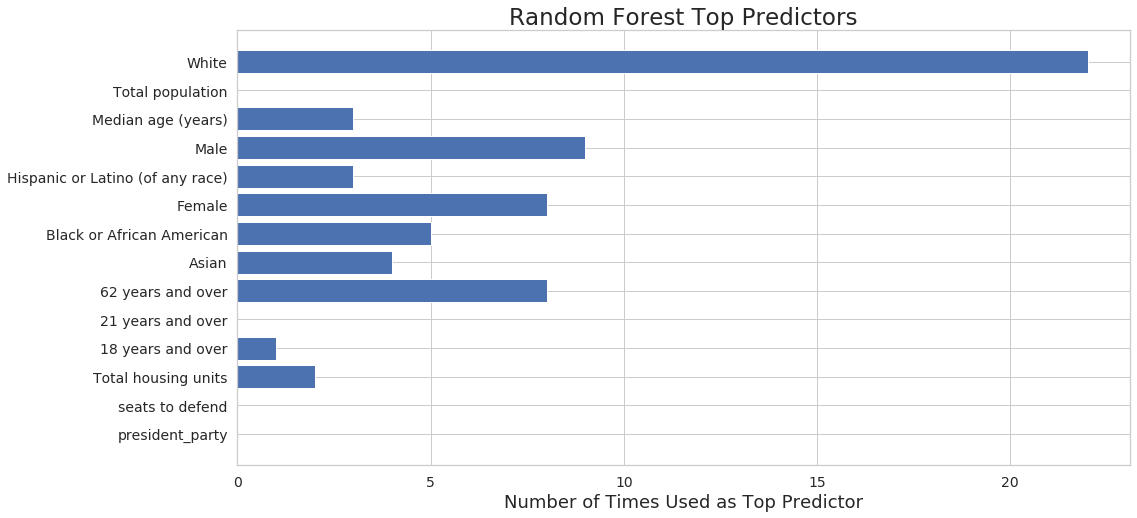

In [0]:

#Find out how many times each feature was used as the decision feature 

#initialize empty dictionaries to put the frequencies into
top_predictors_rf = {}
total_features = x_train_scaled.shape[1]
for i in range(total_features):
    top_predictors_rf['{}'.format(x_train_scaled.columns[i])] = 0

#go through lists of top predictors and input frequencies
for i in range(len(top_preds_rf)):
    top_predictors_rf['{}'.format(x_train_scaled.columns[top_preds_rf[i]])] += 1



#Visual representation of the results
fig, ax = plt.subplots(1,1, figsize=(16, 8))

D = top_predictors_rf
ax.barh(list(D.keys()), list(D.values()), align='center')

ax.set_title('Random Forest Top Predictors', fontsize=f_size)
ax.set_xlabel('Number of Times Used as Top Predictor', fontsize=18)
ax.tick_params(labelsize=14)



### Boosting

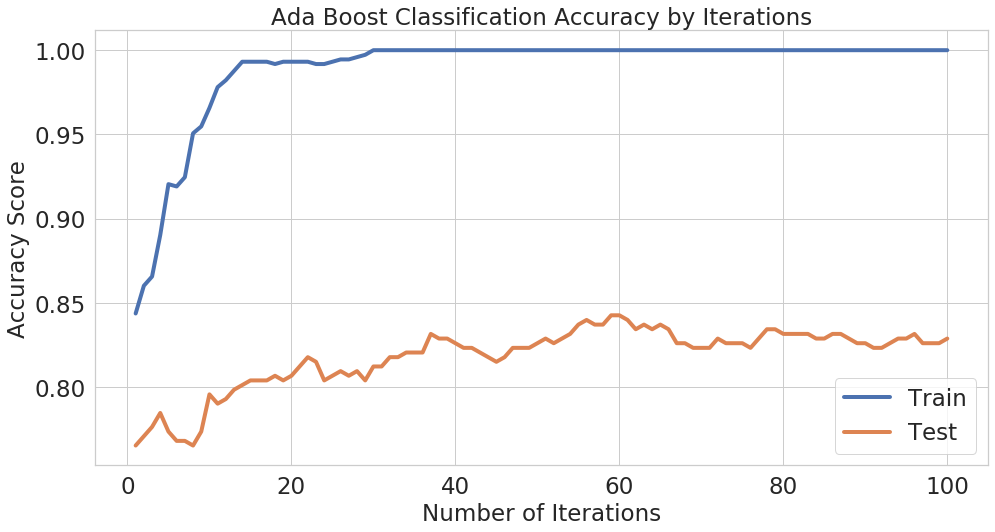

In [0]:
#BOOSTING

#controls for inputs
base_depth = 5
learning_rate = 0.051
iterations = 100

#function to return list of scores by iteration
def make_abc(base_depth, learning_rate, iterations):
    abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=base_depth), learning_rate=learning_rate, n_estimators=iterations)
    abc.fit(x_train_scaled, y_train)

    abc_train_preds = abc.predict(x_train_scaled)
    abc_test_preds = abc.predict(x_test_scaled)

    train_cum_scores = list(abc.staged_score(x_train_scaled, y_train))
    test_cum_scores = list(abc.staged_score(x_test_scaled, y_test))
    
    return train_cum_scores, test_cum_scores


#get train, test list of scores by iteration 
train_cum_scores, test_cum_scores = make_abc(base_depth, learning_rate, iterations)

#graph it 
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
num_iters = np.arange(1, iterations+1)
f_size = 23

ax.plot(num_iters, train_cum_scores , label='Train', lw=4)
ax.plot(num_iters, test_cum_scores , label='Test', lw=4)

ax.set_xlabel('Number of Iterations', fontsize=f_size)
ax.set_ylabel('Accuracy Score', fontsize=f_size)
ax.set_title('Ada Boost Classification Accuracy by Iterations', fontsize=f_size)
ax.legend(loc='best', fontsize=f_size)
ax.tick_params(labelsize=f_size)




In [0]:
#find max accuracy and index of max accuracy 
max_acc_boost = max(test_cum_scores)
acc_boost_id = test_cum_scores.index(max_acc_boost)
print('Max accuracy of {:.4f} \n at {} iterations'.format(max_acc_boost, acc_boost_id))


Max accuracy of 0.8425 
 at 58 iterations


### Neural Networks

In [0]:
NN_model = Sequential()

NN_model.add(Dense(units=100, activation="relu",  kernel_regularizer= regularizers.l1(0.001), input_dim=14))
NN_model.add(Dense(units=100, activation="relu", kernel_regularizer = regularizers.l1(0.002)))
NN_model.add(Dense(units=1000, activation="relu", kernel_regularizer = regularizers.l1(0.001)))
NN_model.add(Dense(units=1, activation="sigmoid"))

NN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
NN_history = NN_model.fit(x_train_scaled, y_train, epochs=2000, validation_split=0.3, batch_size=64)

Train on 510 samples, validate on 219 samples
Epoch 1/2000
510/510 [==============================] - 0s 947us/sample - loss: 5.8701 - acc: 0.5471 - val_loss: 5.3469 - val_acc: 0.6575
Epoch 2/2000
510/510 [==============================] - 0s 86us/sample - loss: 5.0100 - acc: 0.5471 - val_loss: 4.5422 - val_acc: 0.6575
Epoch 3/2000
510/510 [==============================] - 0s 84us/sample - loss: 4.2467 - acc: 0.6157 - val_loss: 3.8477 - val_acc: 0.7443
Epoch 4/2000
510/510 [==============================] - 0s 86us/sample - loss: 3.5752 - acc: 0.6510 - val_loss: 3.2187 - val_acc: 0.7215
Epoch 5/2000
510/510 [==============================] - 0s 97us/sample - loss: 2.9917 - acc: 0.6725 - val_loss: 2.6953 - val_acc: 0.7671
Epoch 6/2000
510/510 [==============================] - 0s 100us/sample - loss: 2.4985 - acc: 0.6863 - val_loss: 2.2482 - val_acc: 0.7671
Epoch 7/2000
510/510 [==============================] - 0s 96us/sample - loss: 2.0948 - acc: 0.7235 - val_loss: 1.9053 - val_acc: 

In [0]:
NN_y_pred = NN_model.predict(x_test_scaled)
accuracy_score(y_test, np.around(NN_y_pred))

0.8121546961325967

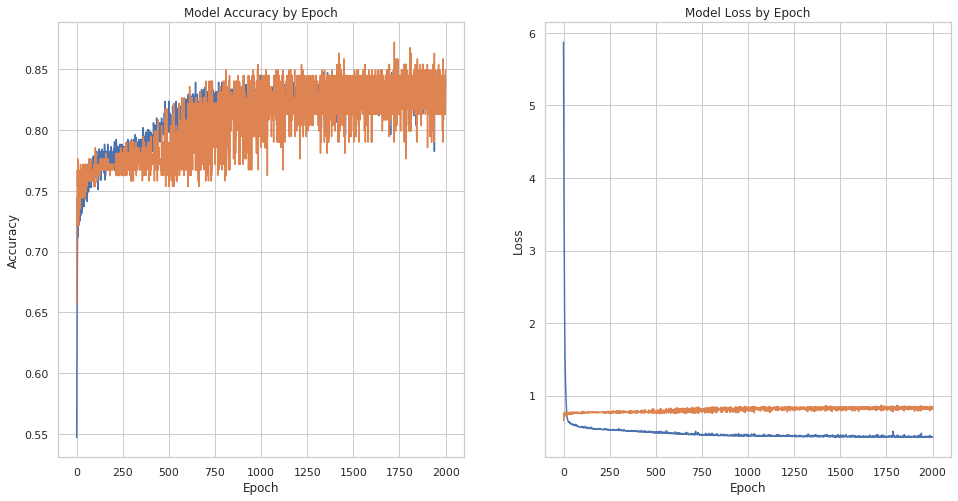

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

axs[0].plot(list(range(2000)), NN_history.history["acc"], label="Accuracy")
axs[0].plot(list(range(2000)), NN_history.history["val_acc"], label="Validation Accuarcy") 
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Model Accuracy by Epoch")

axs[1].plot(list(range(2000)), NN_history.history["loss"], label="Loss")
axs[1].plot(list(range(2000)), NN_history.history["val_acc"], label="Validation Loss") 
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].set_title("Model Loss by Epoch")

fig.show()